# Softmax demo, with histosys!

![](assets/softmax_pyhf_animation.gif)

## This depends on an experimental version of pyhf, install it by running the cell below:

In [1]:
!python -m pip install git+https://github.com/scikit-hep/pyhf.git@diffable_json

  Cloning https://github.com/phinate/pyhf.git (to revision diffable_json) to /private/var/folders/nk/l3bpn5t13lg1qclxj08k_b800000gn/T/pip-req-build-snohxqmh
  Running command git clone -q https://github.com/phinate/pyhf.git /private/var/folders/nk/l3bpn5t13lg1qclxj08k_b800000gn/T/pip-req-build-snohxqmh
  Running command git checkout -b diffable_json --track origin/diffable_json
  Switched to a new branch 'diffable_json'
  Branch 'diffable_json' set up to track remote branch 'diffable_json' from 'origin'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 66 kB 887 kB/s eta 0:00:01
  Using cached click-7.1.2-py2.py3-none-any.whl (82 kB)
  Using cached jsonpointer-2.0-py2.py3-none-any.whl (7.6 kB)
  Created wheel for pyhf: filename=pyhf-0.4.1.dev6-py2.py3-none-any.whl size=96102 sha256=b995a76d0f92cd304941f027dd7f3afa12193fd1bae80e6

In [1]:
import time

import jax
import jax.experimental.optimizers as optimizers
import jax.experimental.stax as stax
import jax.random
from jax.random import PRNGKey
import numpy as np
from functools import partial

import pyhf
pyhf.set_backend('jax')
pyhf.default_backend = pyhf.tensor.jax_backend(precision='64b')

from neos import data, infer, makers

rng = PRNGKey(22)

In [2]:
# regression net
final_layer = 3
init_random_params, predict = stax.serial(
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(1024),
    stax.Relu,
    stax.Dense(final_layer),
    stax.Softmax,
)

## Compose differentiable workflow

In [3]:
dgen = data.generate_blobs(rng, blobs=4) 
hmaker = makers.hists_from_nn(dgen, predict, method='softmax')
nnm = makers.histosys_model_from_hists(hmaker)
get_cls = infer.expected_CLs_upper_limit(nnm, solver_kwargs=dict(pdf_transform=True))

# get_cls returns a list of metrics -- let's just index into the first one (CLs)
def loss(params, test_mu):
    return get_cls(params, test_mu)[0]

### Randomly initialise nn weights and check that we can get the gradient of the loss wrt nn params

In [4]:
_, network = init_random_params(jax.random.PRNGKey(2), (-1, 2))

# gradient wrt nn weights
jax.value_and_grad(loss)(network, test_mu=1.0)

(DeviceArray(0.05995673, dtype=float64),
 [(DeviceArray([[-2.3217741e-04, -1.7894249e-04, -6.0847378e-05, ...,
                  6.3718908e-05,  7.7229757e-05,  2.2041100e-05],
                [ 2.8023310e-04,  1.4383352e-04,  7.4426265e-05, ...,
                 -5.3240507e-05, -1.0534972e-04,  1.1296924e-05]],            dtype=float32),
   DeviceArray([-7.3751187e-05,  6.5396616e-06, -4.4865723e-05, ...,
                -1.6381196e-05,  7.2083632e-05,  1.0425624e-05],            dtype=float32)),
  (),
  (DeviceArray([[ 1.2862045e-06, -1.3878989e-06,  1.5523256e-06, ...,
                 -1.2467436e-07,  2.8923242e-07,  2.0936200e-07],
                [ 1.5300036e-06,  1.8212451e-07,  2.9150870e-06, ...,
                  1.1441897e-07,  9.0753144e-07, -5.0317476e-07],
                [-1.1893795e-07, -1.0953570e-05,  6.7028125e-08, ...,
                 -1.6470675e-06, -2.2597978e-06,  1.5723747e-06],
                ...,
                [ 2.5895874e-06,  5.2436440e-07,  2.9629405e-0

### Define training loop!

In [5]:
opt_init, opt_update, opt_params = optimizers.adam(1e-3)

def train_network(N):
    cls_vals = []
    _, network = init_random_params(jax.random.PRNGKey(1), (-1, 2))
    state = opt_init(network)
    losses = []

    # parameter update function
    # @jax.jit
    def update_and_value(i, opt_state, mu):
        net = opt_params(opt_state)
        value, grad = jax.value_and_grad(loss)(net, mu)
        return opt_update(i, grad, state), value, net

    for i in range(N):
        start_time = time.time()
        state, value, network = update_and_value(i, state, 1.0)
        epoch_time = time.time() - start_time
        losses.append(value)
        metrics = {"loss": losses}
        yield network, metrics, epoch_time

### Plotting helper function for awesome animations :)

In [6]:
# Choose colormap
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
def to_transp(cmap):
    #cmap = pl.cm.Reds_r
    my_cmap = cmap(np.arange(cmap.N))
    #my_cmap[:,-1] = np.geomspace(0.001, 1, cmap.N)
    my_cmap[:,-1] = np.linspace(0, 0.7, cmap.N)
    #my_cmap[:,-1] = np.ones(cmap.N)
    return ListedColormap(my_cmap)

def plot(axarr, network, metrics, maxN):
    xlim = (-5, 5)
    ylim = (-5, 5)
    g = np.mgrid[xlim[0]:xlim[1]:101j, ylim[0]:ylim[1]:101j]
    levels = np.linspace(0, 1, 20)
        
    ax = axarr[0]
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, final_layer)[:, :, 0],
        levels=levels,
        cmap = to_transp(pl.cm.Reds),
    )
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, final_layer)[:, :, 1],
        levels=levels,
        cmap = to_transp(pl.cm.Blues),
    )
  
    ax.contourf(
        g[0],
        g[1],
        predict(network, np.moveaxis(g, 0, -1)).reshape(101, 101, final_layer)[:, :, 2],
        levels=levels,
        cmap = to_transp(pl.cm.Greens),
    )

    sig, bkg_nom, bkg_up, bkg_down = dgen()

    ax.scatter(sig[:, 0], sig[:, 1], alpha=0.3, c="C9")
    ax.scatter(bkg_up[:, 0], bkg_up[:, 1], alpha=0.1, c="C1", marker=6)
    ax.scatter(bkg_down[:, 0], bkg_down[:, 1], alpha=0.1, c="C1", marker=7)
    ax.scatter(bkg_nom[:, 0], bkg_nom[:, 1], alpha=0.3, c="C1")


    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax = axarr[1]
    ax.axhline(0.05, c="slategray", linestyle="--")
    ax.plot(metrics["loss"], c="steelblue", linewidth=2.0)

    ax.set_ylim(0, 0.15)
    ax.set_xlim(0, maxN)
    ax.set_xlabel("epoch")
    ax.set_ylabel(r"$CL_s$")

    ax = axarr[2]
    s, b, bup, bdown = hmaker([network,None])

    bins = np.linspace(0,1,final_layer+1)
    bin_width = 1. / final_layer
    centers = bins[:-1] + np.diff(bins) / 2.0
    ax.bar(centers, b, color="C1", width=bin_width)
    ax.bar(centers, s, bottom=b, color="C9", width=bin_width)

    bunc = np.asarray([[x, y] if x > y else [y, x] for x, y in zip(bup, bdown)])
    plot_unc = []
    for unc, be in zip(bunc, b):
        if all(unc > be):
            plot_unc.append([max(unc), be])
        elif all(unc < be):
            plot_unc.append([be, min(unc)])
        else:
            plot_unc.append(unc)

    plot_unc = np.asarray(plot_unc)
    b_up, b_down = plot_unc[:, 0], plot_unc[:, 1]

    ax.bar(centers, b_up - b, bottom=b, alpha=0.4, color="black", width=bin_width)
    ax.bar(
        centers, b - b_down, bottom=b_down, alpha=0.4, color="black", width=bin_width
    )

    ax.set_ylim(0, 100)
    ax.set_ylabel("frequency")
    ax.set_xlabel("nn output")

## Install celluloid to create animations if you haven't already by running this next cell:

In [13]:
!python -m pip install celluloid

### Let's run it!!

epoch 0: CLs = 0.05996983692115765, took 1.512545108795166s
epoch 1: CLs = 0.030596786927458375, took 2.022122859954834s
epoch 2: CLs = 0.008953316468476746, took 2.060853958129883s
epoch 3: CLs = 0.0019975995692056436, took 1.9914181232452393s
epoch 4: CLs = 0.0005502178847760497, took 2.0072109699249268s
epoch 5: CLs = 0.00020702991665033643, took 2.014936923980713s
epoch 6: CLs = 0.00010119025847199481, took 2.006727933883667s
epoch 7: CLs = 6.000147548346213e-05, took 1.9773640632629395s
epoch 8: CLs = 4.079480919605416e-05, took 2.002415180206299s
epoch 9: CLs = 3.054388948453557e-05, took 2.017674207687378s
epoch 10: CLs = 2.4492523543750977e-05, took 2.083250045776367s
epoch 11: CLs = 2.0634761843663085e-05, took 2.018139123916626s
epoch 12: CLs = 1.802757826063761e-05, took 2.0502779483795166s
epoch 13: CLs = 1.618189460184105e-05, took 2.0046041011810303s
epoch 14: CLs = 1.4823435986466293e-05, took 2.002837896347046s
epoch 15: CLs = 1.379036056659011e-05, took 2.0102739334106

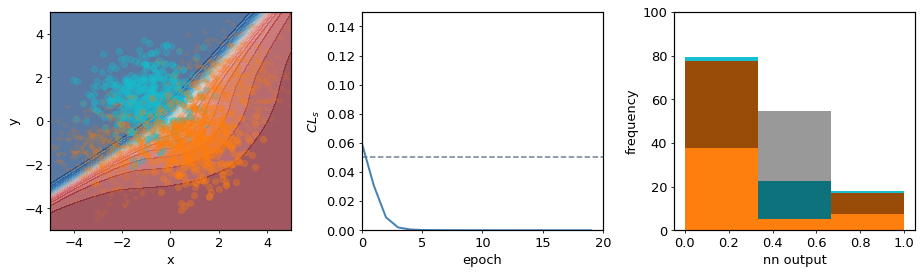

In [7]:
# slow
import numpy as np
from IPython.display import HTML

from matplotlib import pyplot as plt

plt.rcParams.update(
    {
        "axes.labelsize": 13,
        "axes.linewidth": 1.2,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "figure.figsize": [13.0, 4.0],
        "font.size": 13,
        "xtick.major.size": 3,
        "ytick.major.size": 3,
        "legend.fontsize": 11,
    }
)


fig, axarr = plt.subplots(1, 3, dpi=120)

maxN = 20  # make me bigger for better results!

animate = True  # animations fail tests...

if animate:
    from celluloid import Camera

    camera = Camera(fig)

# Training
for i, (network, metrics, epoch_time) in enumerate(train_network(maxN)):
    print(f"epoch {i}:", f'CLs = {metrics["loss"][-1]}, took {epoch_time}s')
    if animate:
        plot(axarr, network, metrics, maxN=maxN)
        plt.tight_layout()
        camera.snap()
        if i % 10 == 0:
            camera.animate().save("animation.gif", writer="imagemagick", fps=8)
            # HTML(camera.animate().to_html5_video())
if animate:
    camera.animate().save("animation.gif", writer="imagemagick", fps=8)